In [1]:
import matplotlib.pyplot as plt
import artm

In [6]:
full_batch_vectorizer = artm.BatchVectorizer(data_path='full_corpus.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
chorus_batch_vectorizer = artm.BatchVectorizer(data_path='ch_corpus.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
verse_batch_vectorizer = artm.BatchVectorizer(data_path='v_corpus.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')

In [7]:
def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates),
             model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()

In [9]:
def artm_results(batch_vectorizer):
    for i in range(2, 7):
        topic_names = ['topic_{}'.format(j) for j in range(i)]
        artm_model = artm.ARTM(topic_names=topic_names, cache_theta=True, dictionary=batch_vectorizer.dictionary,
                                scores=[artm.PerplexityScore(name='PerplexityScore', 
                                                             dictionary=batch_vectorizer.dictionary)],
                                regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                                tau=-0.2)])
        model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True, dictionary=batch_vectorizer.dictionary,
                               scores=[artm.PerplexityScore(name='PerplexityScore',
                                                            dictionary=batch_vectorizer.dictionary)])
        artm_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
        artm_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
        artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=5))
        artm_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.8))
        model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
        model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
        model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.8))
        model_plsa.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=5))
        artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2))
        artm_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5))
        model_plsa.num_document_passes = 1
        artm_model.num_document_passes = 1

        artm_model.scores.add(artm.TopTokensScore(name='TopTokensCoherenceScore'))
        artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
        model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
        artm_top_tokens = artm_model.score_tracker['top_tokens_score'].last_tokens
        plsa_top_tokens = model_plsa.score_tracker['top_tokens_score'].last_tokens

        
        print_measures(model_plsa, artm_model)
        print('ARTM Top Tokens')
        for topic_name in artm_model.topic_names:
            print(artm_top_tokens[topic_name])
        print('PLSA Top Tokens')
        for topic_name in model_plsa.topic_names:
            print(plsa_top_tokens[topic_name])

In [10]:
def lda_results(batch_vectorizer):
    for i in range(2, 7):
        lda_model = artm.LDA(num_topics=i, alpha=0.1, beta=0.001, cache_theta=True,
                             num_document_passes=15, dictionary=batch_vectorizer.dictionary)
        lda_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
        top_tokens = lda_model.get_top_tokens(num_tokens=6)
        for j, token_list in enumerate(top_tokens):
            print('Topic #{0}: {1}'.format(j, token_list))
            print(lda_model.perplexity_value[-1])

### Лирика целиком

Sparsity Phi: 0.027 (PLSA) vs. 0.444 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.979 (PLSA) vs. 0.995 (ARTM)
Kernel purity: 0.652 (PLSA) vs. 0.674 (ARTM)
Perplexity: 1584.318 (PLSA) vs. 1617.697 (ARTM)


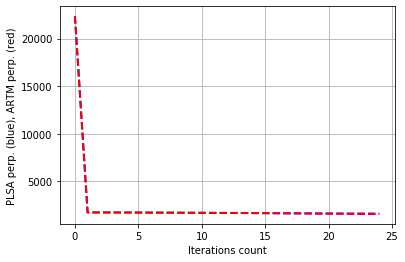

ARTM Top Tokens
['know', 'like', 'let', 'baby', 'fuck']
['love', 'like', 'come', 'tell', 'genre']
PLSA Top Tokens
['know', 'like', 'let', 'baby', 'fuck']
['love', 'like', 'come', 'time', 'tell']
Sparsity Phi: 0.052 (PLSA) vs. 0.601 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.969 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.418 (PLSA) vs. 0.463 (ARTM)
Perplexity: 1545.519 (PLSA) vs. 1575.799 (ARTM)


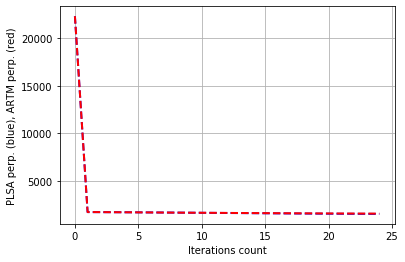

ARTM Top Tokens
['know', 'let', 'love', 'baby', 'fuck']
['love', 'feel', 'wanna', 'like', 'genre']
['like', 'come', 'tell', 'know', 'nigga']
PLSA Top Tokens
['know', 'let', 'like', 'baby', 'fuck']
['love', 'feel', 'genre', 'wanna', 'want']
['like', 'know', 'come', 'tell', 'nigga']
Sparsity Phi: 0.081 (PLSA) vs. 0.691 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.970 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.366 (PLSA) vs. 0.448 (ARTM)
Perplexity: 1455.121 (PLSA) vs. 1494.281 (ARTM)


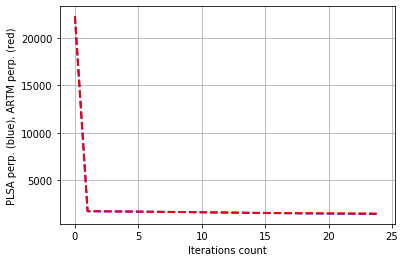

ARTM Top Tokens
['know', 'love', 'let', 'want', 'baby']
['like', 'wanna', 'genre', 'look', 'day']
['like', 'come', 'tell', 'time', 'nigga']
['fuck', 'bitch', 'like', 'shit', 'man']
PLSA Top Tokens
['know', 'love', 'let', 'baby', 'want']
['genre', 'like', 'wanna', 'look', 'life']
['like', 'come', 'know', 'tell', 'time']
['like', 'fuck', 'bitch', 'shit', 'nigga']
Sparsity Phi: 0.110 (PLSA) vs. 0.744 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.972 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.331 (PLSA) vs. 0.452 (ARTM)
Perplexity: 1401.693 (PLSA) vs. 1446.872 (ARTM)


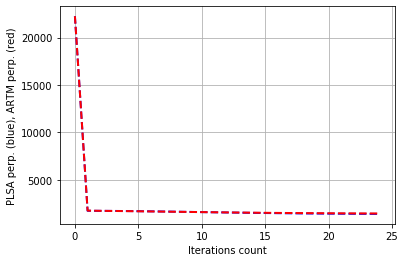

ARTM Top Tokens
['know', 'let', 'want', 'baby', 'love']
['love', 'wanna', 'genre', 'fall', 'day']
['come', 'time', 'tell', 'genre', 'find']
['way', 'man', 'good', 'tell', 'life']
['like', 'fuck', 'bitch', 'nigga', 'shit']
PLSA Top Tokens
['know', 'love', 'let', 'baby', 'want']
['love', 'wanna', 'genre', 'fall', 'hold']
['come', 'know', 'time', 'tell', 'like']
['way', 'good', 'man', 'tell', 'life']
['like', 'bitch', 'fuck', 'nigga', 'shit']
Sparsity Phi: 0.126 (PLSA) vs. 0.781 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.972 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.311 (PLSA) vs. 0.439 (ARTM)
Perplexity: 1370.512 (PLSA) vs. 1417.861 (ARTM)


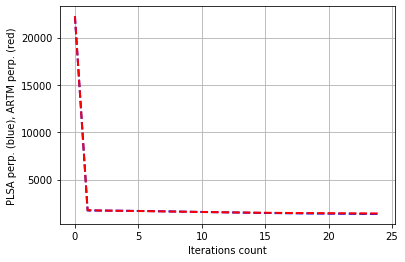

ARTM Top Tokens
['let', 'baby', 'want', 'girl', 'love']
['love', 'wanna', 'heart', 'fall', 'hold']
['come', 'time', 'tell', 'die', 'walk']
['way', 'good', 'life', 'tell', 'look']
['like', 'fuck', 'bitch', 'nigga', 'shit']
['know', 'need', 'bad', 'new', 'think']
PLSA Top Tokens
['love', 'let', 'baby', 'know', 'girl']
['wanna', 'love', 'fall', 'heart', 'hold']
['come', 'time', 'like', 'know', 'tell']
['way', 'good', 'life', 'night', 'tell']
['like', 'fuck', 'bitch', 'nigga', 'shit']
['know', 'love', 'need', 'want', 'bad']


In [11]:
artm_results(full_batch_vectorizer)

In [12]:
lda_results(full_batch_vectorizer)

Topic #0: ['like', 'know', 'bitch', 'fuck', 'nigga', 'shit']
1497.436279296875
Topic #1: ['love', 'know', 'like', 'come', 'time', 'want']
1497.436279296875
Topic #0: ['know', 'like', 'baby', 'girl', 'let', 'fuck']
1413.006591796875
Topic #1: ['love', 'know', 'like', 'time', 'want', 'come']
1413.006591796875
Topic #2: ['like', 'know', 'nigga', 'bitch', 'shit', 'man']
1413.006591796875
Topic #0: ['know', 'love', 'let', 'baby', 'like', 'want']
1332.1654052734375
Topic #1: ['like', 'come', 'time', 'love', 'genre', 'feel']
1332.1654052734375
Topic #2: ['like', 'know', 'come', 'nigga', 'shit', 'bitch']
1332.1654052734375
Topic #3: ['like', 'fuck', 'bitch', 'nigga', 'shit', 'money']
1332.1654052734375
Topic #0: ['know', 'love', 'let', 'baby', 'want', 'girl']
1276.6842041015625
Topic #1: ['love', 'like', 'time', 'genre', 'look', 'come']
1276.6842041015625
Topic #2: ['know', 'come', 'like', 'time', 'tell', 'feel']
1276.6842041015625
Topic #3: ['like', 'man', 'way', 'come', 'let', 'high']
1276.6

### Куплеты

Sparsity Phi: 0.009 (PLSA) vs. 0.346 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.969 (PLSA) vs. 0.985 (ARTM)
Kernel purity: 0.630 (PLSA) vs. 0.643 (ARTM)
Perplexity: 581.394 (PLSA) vs. 585.125 (ARTM)


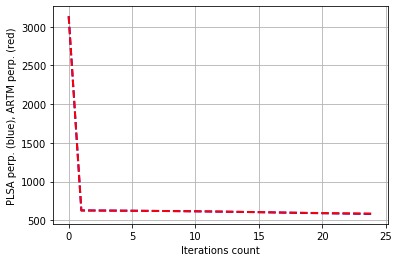

ARTM Top Tokens
['know', 'like', 'let', 'baby', 'fuck']
['love', 'like', 'come', 'tell', 'genre']
PLSA Top Tokens
['know', 'like', 'let', 'baby', 'fuck']
['love', 'like', 'come', 'tell', 'genre']
Sparsity Phi: 0.022 (PLSA) vs. 0.480 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.956 (PLSA) vs. 0.980 (ARTM)
Kernel purity: 0.387 (PLSA) vs. 0.429 (ARTM)
Perplexity: 572.326 (PLSA) vs. 574.451 (ARTM)


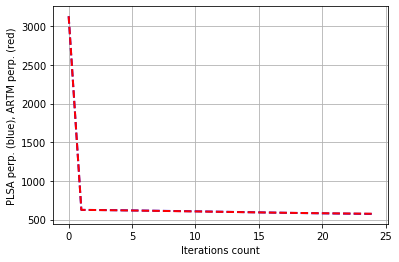

ARTM Top Tokens
['know', 'let', 'love', 'baby', 'fuck']
['love', 'wanna', 'like', 'genre', 'want']
['like', 'come', 'know', 'tell', 'time']
PLSA Top Tokens
['know', 'let', 'like', 'baby', 'fuck']
['love', 'genre', 'wanna', 'feel', 'want']
['know', 'like', 'come', 'tell', 'time']
Sparsity Phi: 0.035 (PLSA) vs. 0.577 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.960 (PLSA) vs. 0.981 (ARTM)
Kernel purity: 0.371 (PLSA) vs. 0.432 (ARTM)
Perplexity: 542.446 (PLSA) vs. 545.708 (ARTM)


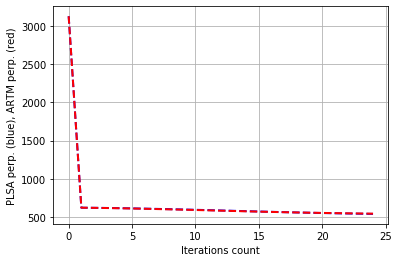

ARTM Top Tokens
['know', 'love', 'let', 'baby', 'want']
['like', 'wanna', 'genre', 'look', 'life']
['come', 'like', 'tell', 'time', 'right']
['fuck', 'bitch', 'like', 'shit', 'man']
PLSA Top Tokens
['love', 'know', 'let', 'baby', 'want']
['genre', 'wanna', 'life', 'look', 'like']
['like', 'come', 'know', 'tell', 'time']
['like', 'fuck', 'bitch', 'nigga', 'shit']
Sparsity Phi: 0.050 (PLSA) vs. 0.633 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.957 (PLSA) vs. 0.980 (ARTM)
Kernel purity: 0.319 (PLSA) vs. 0.416 (ARTM)
Perplexity: 527.192 (PLSA) vs. 532.678 (ARTM)


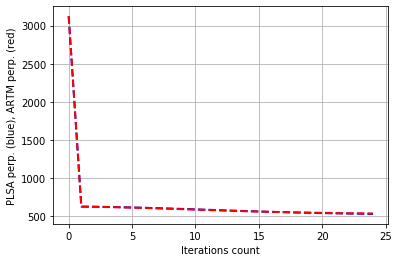

ARTM Top Tokens
['know', 'let', 'want', 'baby', 'girl']
['wanna', 'genre', 'fall', 'day', 'heart']
['come', 'time', 'tell', 'find', 'think']
['way', 'man', 'good', 'tell', 'life']
['like', 'love', 'fuck', 'bitch', 'nigga']
PLSA Top Tokens
['know', 'love', 'let', 'baby', 'want']
['love', 'fall', 'genre', 'wanna', 'hold']
['know', 'come', 'time', 'tell', 'think']
['way', 'man', 'tell', 'good', 'life']
['like', 'bitch', 'fuck', 'nigga', 'shit']
Sparsity Phi: 0.068 (PLSA) vs. 0.675 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.961 (PLSA) vs. 0.980 (ARTM)
Kernel purity: 0.294 (PLSA) vs. 0.425 (ARTM)
Perplexity: 516.579 (PLSA) vs. 521.070 (ARTM)


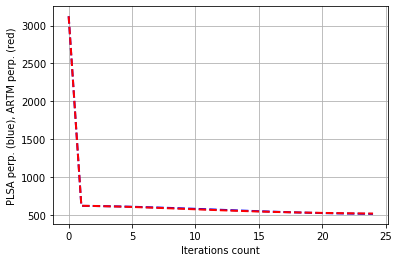

ARTM Top Tokens
['let', 'baby', 'want', 'girl', 'run']
['wanna', 'heart', 'fall', 'hold', 'genre']
['come', 'time', 'tell', 'die', 'walk']
['way', 'good', 'man', 'life', 'night']
['like', 'love', 'fuck', 'bitch', 'nigga']
['know', 'need', 'feel', 'bad', 'new']
PLSA Top Tokens
['let', 'baby', 'love', 'girl', 'know']
['wanna', 'fall', 'heart', 'hold', 'love']
['come', 'time', 'like', 'know', 'tell']
['way', 'good', 'night', 'come', 'life']
['like', 'fuck', 'bitch', 'nigga', 'shit']
['know', 'love', 'need', 'feel', 'want']


In [13]:
artm_results(chorus_batch_vectorizer)

In [14]:
lda_results(chorus_batch_vectorizer)

Topic #0: ['like', 'know', 'bitch', 'fuck', 'nigga', 'girl']
553.2182006835938
Topic #1: ['love', 'know', 'like', 'come', 'time', 'want']
553.2182006835938
Topic #0: ['know', 'like', 'baby', 'girl', 'let', 'fuck']
531.5853271484375
Topic #1: ['love', 'know', 'like', 'time', 'feel', 'want']
531.5853271484375
Topic #2: ['like', 'know', 'nigga', 'bitch', 'shit', 'tell']
531.5853271484375
Topic #0: ['know', 'love', 'let', 'baby', 'want', 'girl']
504.7909240722656
Topic #1: ['like', 'come', 'time', 'genre', 'love', 'feel']
504.7909240722656
Topic #2: ['know', 'like', 'come', 'tell', 'man', 'shit']
504.7909240722656
Topic #3: ['like', 'fuck', 'bitch', 'nigga', 'shit', 'niggas']
504.7909240722656
Topic #0: ['know', 'love', 'let', 'baby', 'want', 'girl']
489.48004150390625
Topic #1: ['love', 'like', 'genre', 'time', 'look', 'feel']
489.48004150390625
Topic #2: ['know', 'come', 'like', 'time', 'tell', 'genre']
489.48004150390625
Topic #3: ['like', 'man', 'tell', 'high', 'come', 'way']
489.48004

### Припевы

Sparsity Phi: 0.027 (PLSA) vs. 0.444 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.979 (PLSA) vs. 0.995 (ARTM)
Kernel purity: 0.652 (PLSA) vs. 0.674 (ARTM)
Perplexity: 1584.317 (PLSA) vs. 1617.697 (ARTM)


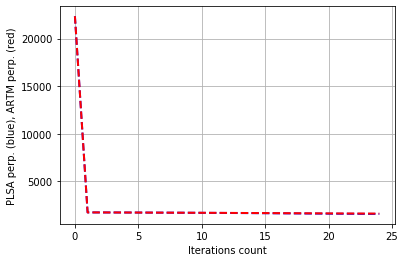

ARTM Top Tokens
['know', 'like', 'let', 'baby', 'fuck']
['love', 'like', 'come', 'tell', 'genre']
PLSA Top Tokens
['know', 'like', 'let', 'baby', 'fuck']
['love', 'like', 'come', 'time', 'tell']
Sparsity Phi: 0.052 (PLSA) vs. 0.601 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.969 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.418 (PLSA) vs. 0.463 (ARTM)
Perplexity: 1545.519 (PLSA) vs. 1575.799 (ARTM)


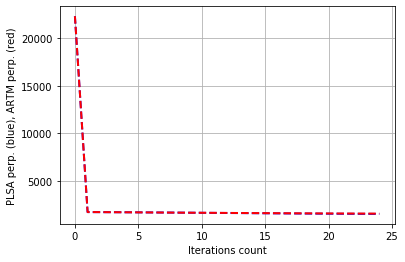

ARTM Top Tokens
['know', 'let', 'love', 'baby', 'fuck']
['love', 'feel', 'wanna', 'like', 'genre']
['like', 'come', 'tell', 'know', 'nigga']
PLSA Top Tokens
['know', 'let', 'like', 'baby', 'fuck']
['love', 'feel', 'genre', 'wanna', 'want']
['like', 'know', 'come', 'tell', 'nigga']
Sparsity Phi: 0.081 (PLSA) vs. 0.691 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.970 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.366 (PLSA) vs. 0.448 (ARTM)
Perplexity: 1455.121 (PLSA) vs. 1494.281 (ARTM)


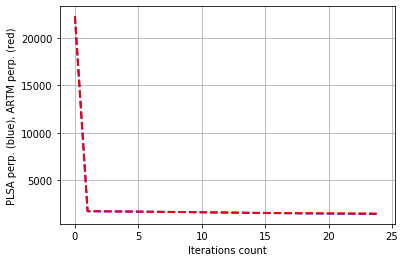

ARTM Top Tokens
['know', 'love', 'let', 'want', 'baby']
['like', 'wanna', 'genre', 'look', 'day']
['like', 'come', 'tell', 'time', 'nigga']
['fuck', 'bitch', 'like', 'shit', 'man']
PLSA Top Tokens
['know', 'love', 'let', 'baby', 'want']
['genre', 'like', 'wanna', 'look', 'life']
['like', 'come', 'know', 'tell', 'time']
['like', 'fuck', 'bitch', 'shit', 'nigga']
Sparsity Phi: 0.110 (PLSA) vs. 0.744 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.972 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.331 (PLSA) vs. 0.452 (ARTM)
Perplexity: 1401.693 (PLSA) vs. 1446.871 (ARTM)


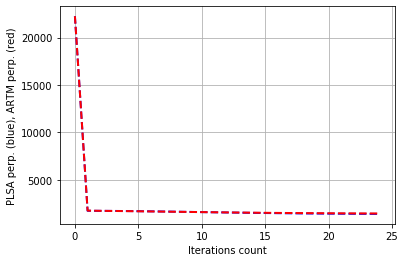

ARTM Top Tokens
['know', 'let', 'want', 'baby', 'love']
['love', 'wanna', 'genre', 'fall', 'day']
['come', 'time', 'tell', 'genre', 'find']
['way', 'man', 'good', 'tell', 'life']
['like', 'fuck', 'bitch', 'nigga', 'shit']
PLSA Top Tokens
['know', 'love', 'let', 'baby', 'want']
['love', 'wanna', 'genre', 'fall', 'hold']
['come', 'know', 'time', 'tell', 'like']
['way', 'good', 'man', 'tell', 'life']
['like', 'bitch', 'fuck', 'nigga', 'shit']
Sparsity Phi: 0.126 (PLSA) vs. 0.781 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.972 (PLSA) vs. 0.994 (ARTM)
Kernel purity: 0.311 (PLSA) vs. 0.439 (ARTM)
Perplexity: 1370.512 (PLSA) vs. 1417.861 (ARTM)


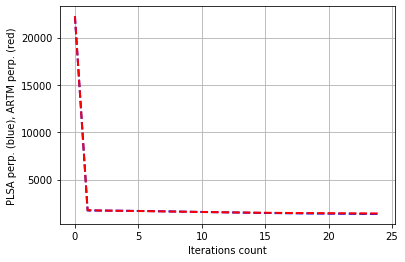

ARTM Top Tokens
['let', 'baby', 'want', 'girl', 'love']
['love', 'wanna', 'heart', 'fall', 'hold']
['come', 'time', 'tell', 'die', 'walk']
['way', 'good', 'life', 'tell', 'look']
['like', 'fuck', 'bitch', 'nigga', 'shit']
['know', 'need', 'bad', 'new', 'think']
PLSA Top Tokens
['love', 'let', 'baby', 'know', 'girl']
['wanna', 'love', 'fall', 'heart', 'hold']
['come', 'time', 'like', 'know', 'tell']
['way', 'good', 'life', 'night', 'tell']
['like', 'fuck', 'bitch', 'nigga', 'shit']
['know', 'love', 'need', 'want', 'bad']


In [15]:
artm_results(verse_batch_vectorizer)

In [16]:
lda_results(verse_batch_vectorizer)

Topic #0: ['like', 'know', 'bitch', 'fuck', 'nigga', 'shit']
1497.4361572265625
Topic #1: ['love', 'know', 'like', 'come', 'time', 'want']
1497.4361572265625
Topic #0: ['know', 'like', 'baby', 'girl', 'let', 'fuck']
1413.0064697265625
Topic #1: ['love', 'know', 'like', 'time', 'want', 'come']
1413.0064697265625
Topic #2: ['like', 'know', 'nigga', 'bitch', 'shit', 'man']
1413.0064697265625
Topic #0: ['know', 'love', 'let', 'baby', 'like', 'want']
1332.165283203125
Topic #1: ['like', 'come', 'time', 'love', 'genre', 'feel']
1332.165283203125
Topic #2: ['like', 'know', 'come', 'nigga', 'shit', 'bitch']
1332.165283203125
Topic #3: ['like', 'fuck', 'bitch', 'nigga', 'shit', 'money']
1332.165283203125
Topic #0: ['know', 'love', 'let', 'baby', 'want', 'girl']
1276.6842041015625
Topic #1: ['love', 'like', 'time', 'genre', 'look', 'come']
1276.6842041015625
Topic #2: ['know', 'come', 'like', 'time', 'tell', 'feel']
1276.6842041015625
Topic #3: ['like', 'man', 'way', 'come', 'let', 'high']
1276.